In [2]:
import os
import sys
import glob
import pandas as pd
import math
import matplotlib.pyplot as plt
import celldancer as cd
import celldancer.cdplt as cdplt
from celldancer.cdplt import colormap
import scvelo as scv
import scanpy as sc
import celldancer.utilities as cdutil
import numpy as np
import seaborn as sns

In [2]:
adata = scv.read("adata_postpro.h5ad")

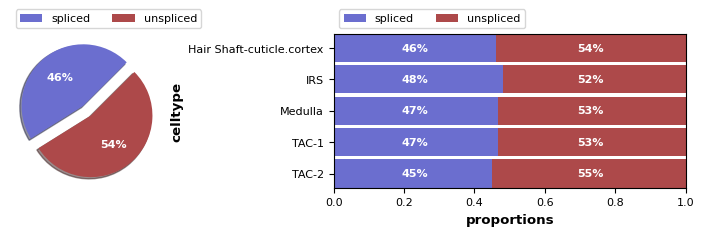

In [3]:
scv.pl.proportions(adata, groupby = "celltype")

In [4]:
cdutil.adata_to_df_with_embed(adata,
                              us_para = ['Mu','Ms'],
                              cell_type_para = 'celltype',
                              embed_para = 'X_umap',
                              save_path = 'celldancer_predata.csv')

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 962/962 [00:09<00:00, 97.19it/s]


,gene_name,unsplice,splice,cellID,clusters,embedding1,embedding2
0,1700025G04Rik,0.054947,0.006496,"R1.01,R2.06,R3.83,P1.07",TAC-1,1.287024,-9.679595
1,1700025G04Rik,0.093957,0.031913,"R1.01,R2.11,R3.86,P1.08",TAC-1,1.679156,-8.890386
2,1700025G04Rik,0.184886,0.007344,"R1.01,R2.15,R3.09,P1.07",TAC-1,3.105708,-11.200886
3,1700025G04Rik,0.154269,0.031217,"R1.01,R2.17,R3.81,P1.05",TAC-1,1.942233,-9.400400
4,1700025G04Rik,0.213829,0.037076,"R1.01,R2.18,R3.95,P1.06",TAC-1,0.205076,-10.888144
...,...,...,...,...,...,...,...
6191427,Zzef1,0.044548,0.040384,"R1.96,R2.73,R3.72,P1.08",Hair Shaft-cuticle.cortex,3.055355,-9.896197
6191428,Zzef1,0.142423,0.138429,"R1.96,R2.82,R3.52,P1.07",Hair Shaft-cuticle.cortex,6.997319,-12.901021
6191429,Zzef1,0.132262,0.127907,"R1.96,R2.83,R3.68,P1.06",Hair Shaft-cuticle.cortex,5.877316,-13.320601
6191430,Zzef1,0.069920,0.040305,"R1.96,R2.87,R3.63,P1.07",Hair Shaft-cuticle.cortex,7.729002,-12.868301


In [5]:
cell_type_u_s = pd.read_csv('celldancer_predata.csv')

In [6]:
loss_df, cellDancer_df = cd.velocity(cell_type_u_s, permutation_ratio = 0.125, n_jobs = 16)

Using /media/data/bmi111/KuanChiun/temp/MultiVelo/thesis/results/Mouse_skin/cellDancer_velocity_2024-05-15 15-24-47 as the output path.
Arranging genes for parallel job.
962  genes were arranged to  61  portions.



Velocity Estimation: 100%|██████████| 61/61 [03:52<00:00,  3.21s/it]                                                                                                                                                                                                                 
                                                                                                                                                                                                                                                                                     

In [6]:
cellDancer_df=cd.compute_cell_velocity(cellDancer_df=cellDancer_df, projection_neighbor_choice='gene', expression_scale='power10', projection_neighbor_size=200)

Caution! Overwriting the 'velocity' columns.


Pseudo random number generator seeds are set to:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


Generating Trajectories: 100%|██████████████████████████████████████████████████████████████████████████| 12250/12250 [00:00<00:00, 15172.37it/s]


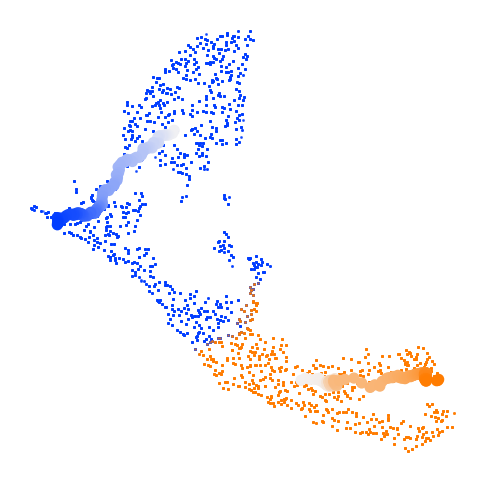

There are 2 clusters.
[0 1]
--- 129.51609420776367 seconds ---


In [7]:
import random
# set parameters
dt = 0.05
t_total = {dt:int(10/dt)}
n_repeats = 10

# estimate pseudotime
cellDancer_df = cd.pseudo_time(cellDancer_df=cellDancer_df,
                               grid=(30,30),
                               dt=dt,
                               t_total=t_total[dt],
                               n_repeats=n_repeats,
                               speed_up=(100,100),
                               n_paths = 2,
                               plot_long_trajs=True,
                               psrng_seeds_diffusion=[i for i in range(n_repeats)],
                               n_jobs=8)

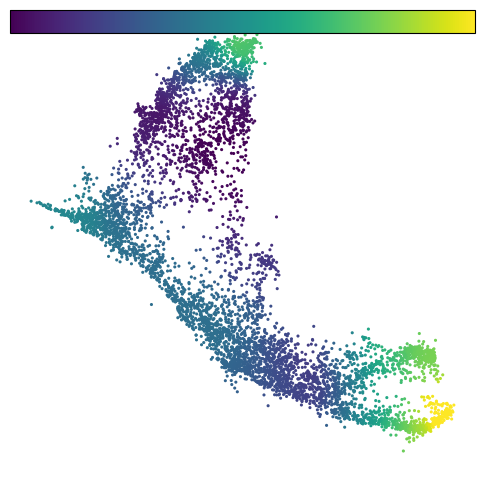

In [8]:
# plot pseudotime
fig, ax = plt.subplots(figsize=(6,6))
im=cdplt.scatter_cell(ax,cellDancer_df, colors='pseudotime', alpha=1.0, velocity=False)
ax.axis('off')
plt.show()

In [9]:
cellDancer_df.to_csv("data/celldancer_result.csv")

In [10]:
adata_celldancer = cdutil.to_dynamo(cellDancer_df)

In [11]:
adata_celldancer

AnnData object with n_obs × n_vars = 6436 × 962
    obs: 'clusters'
    var: 'highly_variable_genes', 'loss', 'use_for_dynamics', 'use_for_transition'
    uns: 'dynamics'
    obsm: 'X_cdr', 'velocity_cdr'
    layers: 'X_spliced', 'X_unspliced', 'M_s', 'M_u', 'velocity_S', 'velocity_U', 'alpha', 'beta', 'gamma'
    obsp: 'connectivities', 'distances'

In [12]:
clusters = list(cellDancer_df["cellID"][0:6436])

In [13]:
times = list(cellDancer_df["pseudotime"][0:6436])

In [14]:
match_dict = {k:v for k, v in zip(clusters, times)}

In [15]:
cellID = adata_celldancer.obs_names

In [16]:
pseudotime = [match_dict[item] for item in cellID]

In [17]:
adata_celldancer.obs["pseudotime"] = pseudotime

In [18]:
adata_celldancer.write_h5ad("data/celldancer.h5ad")